# Lesson 15: Data Wrangling Demonstration

This notebook demonstrates key data wrangling techniques for handling outliers and missing data.

We'll investigate:

**1. Handling Missing Data**

- **Mean Imputation**: Replace missing values with the column mean
- **Median Imputation**: Replace missing values with the column median
- **KNN Imputation**: Replace missing values using K-Nearest Neighbors
- **Iterative Imputation**: Replace missing values using multivariate imputation (MICE algorithm)

**2. Detecting Outliers**

- **IQR Method**: Uses the Interquartile Range (Q3 - Q1) to identify outliers
- **Z-Score Method**: Identifies values more than 3 standard deviations from the mean
- **Isolation Forest**: Machine learning method that isolates anomalies
- **Local Outlier Factor (LOF)**: Density-based method identifying points with lower density than neighbors

**3. Handling Outliers**

- **Removal**: Remove outlier observations from the dataset
- **Capping (Winsorization)**: Replace outliers with boundary values (e.g., 5th and 95th percentiles)
- **Binning (Discretization)**: Convert continuous values into discrete bins
- **Log Transformation**: Apply logarithmic transformation to compress the range of values


## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.gridspec import GridSpec
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.neighbors import LocalOutlierFactor

## Load Datasets

In [ ]:
df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/salted_housing_data.csv')
df_original = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,NaN,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,NaN,565.0,2.181467,37.85,NaN,3.422


## 1. Handling Missing Data

Let's look at the missing data in the `MedInc` feature.

In [3]:
feature = 'MedInc'

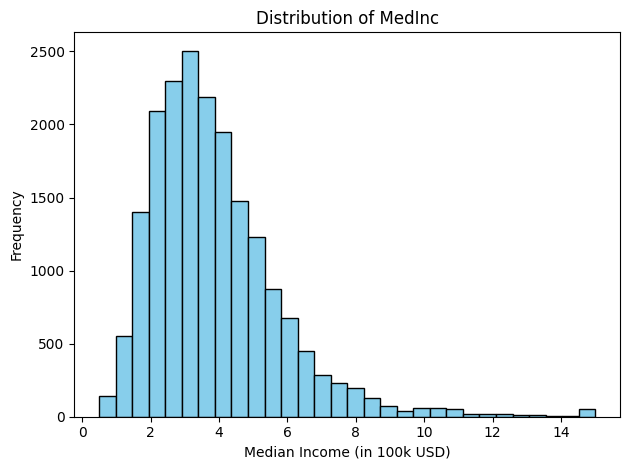

In [4]:
plt.title(f'Distribution of {feature}')

plt.hist(df[feature], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Median Income (in 100k USD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 1.1. Check for missing values

In [5]:
print(f'{feature} contains {df[feature].isnull().sum()} missing values.')

MedInc contains 1546 missing values.


### 1.2. Fill (impute) missing values
#### Mean imputation

In [6]:
df_mean = df.copy()
df_mean.fillna({feature: df_mean[feature].mean()}, inplace=True)

print(f"Mean imputation value: {df[feature].mean():.2f}")

Mean imputation value: 3.87


#### Median imputation

In [7]:
df_median = df.copy()
df_median.fillna({feature: df_median[feature].median()}, inplace=True)

print(f"Median imputation value: {df[feature].median():.2f}")

Median imputation value: 3.53


#### KNN imputation

Uses all features to find nearest neighbors. This allows the imputer to leverage relationships between features.

In [ ]:
knn_imputer = KNNImputer(n_neighbors=5)
df_knn_full = knn_imputer.fit_transform(df)

# Extract the feature of interest
df_knn = pd.DataFrame(
    df_knn_full[:, df.columns.get_loc(feature)],
    columns=[feature],
    index=df.index
)

print(f"KNN imputation uses 5 nearest neighbors across all {len(df.columns)} features")

#### Iterative imputation

Models each feature as a function of others. This allows the imputer to capture multivariate relationships.

In [ ]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
df_iterative_full = iterative_imputer.fit_transform(df)

# Extract the feature of interest
df_iterative = pd.DataFrame(
    df_iterative_full[:, df.columns.get_loc(feature)],
    columns=[feature],
    index=df.index
)

print(f"Iterative imputation models relationships across all {len(df.columns)} features")

### 1.2. Compare Imputation Results

Visualizing how different imputation methods affect the distribution.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Create KDE of original distribution
kde_original = stats.gaussian_kde(df[feature].dropna())
x_range = np.linspace(df[feature].min(), df[feature].max(), 200)
kde_values = kde_original(x_range)

# Mean imputation
axes[0, 0].set_title('Mean Imputation')

axes[0, 0].hist(
    df_mean[feature],
    bins=30, density=True,
    edgecolor='black', color='green', 
    label='Mean Imputed'
)

axes[0, 0].plot(
    x_range, kde_values,
    'b-', linewidth=2.5,
    label='Original Distribution'
)

axes[0, 0].set_xlabel(feature)
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend(loc='upper right')

# Median imputation
axes[0, 1].set_title('Median Imputation')

axes[0, 1].hist(
    df_median[feature],
    bins=30, density=True,
    edgecolor='black', color='orange',
    label='Median Imputed'
)

axes[0, 1].plot(
    x_range, kde_values,
    'b-', linewidth=2.5,
    label='Original Distribution'
)

axes[0, 1].set_xlabel(feature)
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend(loc='upper right')

# KNN imputation
axes[1, 0].set_title('KNN Imputation')

axes[1, 0].hist(
    df_knn[feature],
    bins=30, density=True,
    edgecolor='black', color='purple',
    label='KNN Imputed'
)

axes[1, 0].plot(
    x_range, kde_values,
    'b-', linewidth=2.5,
    label='Original Distribution'
)

axes[1, 0].set_xlabel(feature)
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend(loc='upper right')

# Iterative imputation
axes[1, 1].set_title('Iterative Imputation (MICE)')

axes[1, 1].hist(
    df_iterative[feature],
    bins=30, density=True,
    edgecolor='black', color='teal',
    label='Iterative Imputed'
)

axes[1, 1].plot(
    x_range, kde_values,
    'b-', linewidth=2.5,
    label='Original Distribution'
)

axes[1, 1].set_xlabel(feature)
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend(loc='upper right')

plt.tight_layout()
plt.show()

## 2. Outlier Detection Methods

This section demonstrates four common methods for detecting outliers in data.

We'll compare:
- **IQR Method**: Uses the Interquartile Range (Q3 - Q1) to identify outliers
- **Z-Score Method**: Identifies values that are more than 3 standard deviations from the mean
- **Isolation Forest**: Machine learning method that isolates anomalies
- **Local Outlier Factor (LOF)**: Density-based method that identifies points with lower density than their neighbors

### 2.1. Visualize Feature for Outlier Detection

Let's examine the `MedHouseVal` (median house value) feature, which often contains outliers.

In [ ]:
outlier_feature = 'MedHouseVal'

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Histogram
axes[0].set_title(f'Distribution of {outlier_feature}')

axes[0].hist(
    df_original[outlier_feature],
    bins=50,
    color='skyblue',
    edgecolor='black',
)

axes[0].set_xlabel('Median House Value ($100k)')
axes[0].set_ylabel('Frequency')

# Box plot
axes[1].set_title(f'Box Plot of {outlier_feature}')

axes[1].boxplot(
    df_original[outlier_feature],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='skyblue'),
    medianprops=dict(color='black'),
    flierprops=dict(marker='o', markerfacecolor='red', markersize=5)
)

axes[1].set_ylabel('Median House Value ($100k)')
axes[0].set_xlabel('')

plt.tight_layout()
plt.show()

### 2.2. Method 1: IQR (Interquartile Range) Method

The IQR method defines outliers as values that fall below Q1 - 1.5×IQR or above Q3 + 1.5×IQR.

In [ ]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    """
    Detect outliers using the IQR method.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - multiplier: IQR multiplier (typically 1.5 for outliers, 3.0 for extreme outliers)
    
    Returns:
    - Boolean series indicating outliers
    """

    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    
    return outliers

outliers_iqr = detect_outliers_iqr(df_original, outlier_feature)

### 2.3. Method 2: Z-Score Method

The Z-Score method identifies outliers as values with a z-score greater than 3 (or less than -3), meaning they are more than 3 standard deviations from the mean.

In [ ]:
def detect_outliers_zscore(data, column, threshold=3):
    """
    Detect outliers using the Z-Score method.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - threshold: z-score threshold (typically 3)
    
    Returns:
    - Boolean series indicating outliers
    """

    mean = data[column].mean()
    std = data[column].std()
    z_scores = np.abs((data[column] - mean) / std)
    
    outliers = z_scores > threshold
    
    return outliers

outliers_zscore = detect_outliers_zscore(df_original, outlier_feature)

### 2.4. Method 3: Isolation Forest

Isolation Forest is a machine learning algorithm specifically designed for anomaly detection. It works by randomly partitioning the data and identifying points that are quickly isolated.

In [ ]:
def detect_outliers_isolation_forest(data, column, contamination=0.05):
    """
    Detect outliers using Isolation Forest.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - contamination: expected proportion of outliers (default 0.05 = 5%)
    
    Returns:
    - Boolean series indicating outliers
    """
    # Isolation Forest requires 2D array
    X = data[[column]].values
    
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    predictions = iso_forest.fit_predict(X)
    
    # Isolation Forest returns -1 for outliers, 1 for inliers
    outliers = predictions == -1
    
    return outliers

outliers_iforest = detect_outliers_isolation_forest(df_original, outlier_feature)

### 2.5. Method 4: Local Outlier Factor (LOF)

Local Outlier Factor identifies outliers by measuring the local density deviation of a data point with respect to its neighbors. Points with substantially lower density than their neighbors are considered outliers.

In [ ]:
def detect_outliers_lof(data, column, n_neighbors=1000):
    """
    Detect outliers using Local Outlier Factor.
    
    Parameters:
    - data: DataFrame
    - column: column name to check for outliers
    - n_neighbors: number of neighbors to consider (default 1000)
    
    Returns:
    - Boolean series indicating outliers
    """

    # LOF requires 2D array
    X = data[[column]].values
    
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    predictions = lof.fit_predict(X)
    
    # LOF returns -1 for outliers, 1 for inliers
    outliers = predictions == -1

    return outliers

outliers_lof = detect_outliers_lof(df_original, outlier_feature)

### 2.6. Compare Outlier Detection Methods

Let's visualize how each method identifies outliers.

In [ ]:
# Precompute 30 bins for consistent histogram display across all methods
n_hist_bins = 30

hist_bins = np.linspace(
    df_original[outlier_feature].min(), 
    df_original[outlier_feature].max(), 
    n_hist_bins + 1
)

fig = plt.figure(figsize=(8, 11))
gs = GridSpec(4, 2, figure=fig, width_ratios=[4, 1], hspace=0.4, wspace=0.05)
fig.supylabel('Median House Value ($100k)')

# IQR Method
ax_scatter = fig.add_subplot(gs[0, 0])
ax_scatter.set_title(f'IQR Method: {outliers_iqr.sum()} outliers detected')

ax_scatter.scatter(
    df_original.index[~outliers_iqr],
    df_original.loc[~outliers_iqr, outlier_feature], 
    c='teal', alpha=0.5, s=5
)

ax_scatter.scatter(
    df_original.index[outliers_iqr],
    df_original.loc[outliers_iqr, outlier_feature], 
    c='orange', s=5, label='Outliers'
)

ax_scatter.set_ylabel('')
ax_scatter.legend(loc='lower left', framealpha=1, markerscale=3)

ax_hist = fig.add_subplot(gs[0, 1], sharey=ax_scatter)
ax_hist.hist(
    df_original.loc[~outliers_iqr, outlier_feature],
    bins=hist_bins, orientation='horizontal', 
    color='teal', edgecolor='black'
)

ax_hist.hist(
    df_original.loc[outliers_iqr, outlier_feature],
    bins=hist_bins, orientation='horizontal', 
    color='orange', edgecolor='black'
)

ax_hist.tick_params(labelleft=False)
ax_hist.set_xlabel('Count', fontsize=10)

# Z-Score Method
ax_scatter = fig.add_subplot(gs[1, 0])
ax_scatter.set_title(f'Z-Score Method: {outliers_zscore.sum()} outliers detected')

ax_scatter.scatter(
    df_original.index[~outliers_zscore], df_original.loc[~outliers_zscore, outlier_feature], 
    c='teal', alpha=0.5, s=5
)

ax_scatter.scatter(
    df_original.index[outliers_zscore], df_original.loc[outliers_zscore, outlier_feature], 
    c='orange', s=5, label='Outliers'
)

ax_scatter.set_ylabel('')
ax_scatter.legend(loc='lower left', framealpha=1, markerscale=3)

ax_hist = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_hist.hist(
    df_original.loc[~outliers_zscore, outlier_feature],
    bins=hist_bins, orientation='horizontal', 
    color='teal', edgecolor='black'
)
ax_hist.hist(
    df_original.loc[outliers_zscore, outlier_feature],
    bins=hist_bins, orientation='horizontal', 
    color='orange', edgecolor='black'
)
ax_hist.tick_params(labelleft=False)
ax_hist.set_xlabel('Count', fontsize=10)

# Isolation Forest
ax_scatter = fig.add_subplot(gs[2, 0])
ax_scatter.set_title(f'Isolation Forest: {outliers_iforest.sum()} outliers detected')

ax_scatter.scatter(
    df_original.index[~outliers_iforest], df_original.loc[~outliers_iforest, outlier_feature], 
    c='teal', alpha=0.5, s=5
)

ax_scatter.scatter(
    df_original.index[outliers_iforest], df_original.loc[outliers_iforest, outlier_feature], 
    c='orange', s=5, label='Outliers'
)

ax_scatter.set_ylabel('')
ax_scatter.legend(loc='lower left', framealpha=1, markerscale=3)

ax_hist = fig.add_subplot(gs[2, 1], sharey=ax_scatter)
ax_hist.hist(
    df_original.loc[~outliers_iforest, outlier_feature],
    bins=hist_bins,
    orientation='horizontal', 
    color='teal', edgecolor='black'
)

ax_hist.hist(
    df_original.loc[outliers_iforest, outlier_feature],
    bins=hist_bins, orientation='horizontal', 
    color='orange', edgecolor='black'
)

ax_hist.tick_params(labelleft=False)
ax_hist.set_xlabel('Count', fontsize=10)

# Local Outlier Factor
ax_scatter = fig.add_subplot(gs[3, 0])
ax_scatter.set_title(f'Local Outlier Factor: {outliers_lof.sum()} outliers detected')

ax_scatter.scatter(
    df_original.index[~outliers_lof], df_original.loc[~outliers_lof, outlier_feature], 
    c='teal', alpha=0.5, s=5
)

ax_scatter.scatter(
    df_original.index[outliers_lof], df_original.loc[outliers_lof, outlier_feature], 
    c='orange', alpha=0.7, s=5, label='Outliers'
)

ax_scatter.set_xlabel('Index')
ax_scatter.set_ylabel('')
ax_scatter.legend(loc='lower left', framealpha=1, markerscale=3)

ax_hist = fig.add_subplot(gs[3, 1], sharey=ax_scatter)
ax_hist.hist(
    df_original.loc[~outliers_lof, outlier_feature],
    bins=hist_bins, orientation='horizontal', 
    color='teal', edgecolor='black'
)

ax_hist.hist(
    df_original.loc[outliers_lof, outlier_feature],
    bins=hist_bins, orientation='horizontal', 
    color='orange', edgecolor='black'
)

ax_hist.tick_params(labelleft=False)
ax_hist.set_xlabel('Count', fontsize=10)

plt.subplots_adjust(left=0.075)
plt.show()

## 3. Handling Outliers

Once outliers are detected, we need to decide how to handle them. This section demonstrates four common approaches.

We'll compare:
- **Removal**: Simply remove outlier observations from the dataset
- **Capping (Winsorization)**: Replace outliers with boundary values (e.g., 5th and 95th percentiles)
- **Binning (Discretization)**: Convert continuous values into discrete bins
- **Log Transformation**: Apply logarithmic transformation to compress the range of values

### 3.1. Method 1: Removal

The simplest approach is to remove outliers from the dataset. We'll use the IQR method to identify outliers.

In [ ]:
# Method 1: Remove outliers
df_removed = df_original[~outliers_iqr].copy()

### 3.2. Method 2: Capping (Winsorization)

Instead of removing outliers, we can cap them at specific percentiles (e.g., 5th and 95th percentiles). This preserves the sample size while limiting extreme values.

In [ ]:
# Method 2: Cap outliers at percentiles
lower_percentile = df_original[outlier_feature].quantile(0.05)
upper_percentile = df_original[outlier_feature].quantile(0.95)

df_capped = df_original.copy()
df_capped[outlier_feature] = df_capped[outlier_feature].clip(lower=lower_percentile, upper=upper_percentile)

# Count how many values were capped
n_capped_lower = (df_original[outlier_feature] < lower_percentile).sum()
n_capped_upper = (df_original[outlier_feature] > upper_percentile).sum()

### 3.3. Method 3: Binning (Discretization)

Binning converts continuous values into discrete categories, reducing the impact of outliers by grouping extreme values with similar values into bins.

In [ ]:
# Method 3: Binning into 30 equal-width bins
df_binned = df_original.copy()

# Create 10 equal-width bins
n_bins = 10

# Store the binned result to extract bin edges
binned_result, bin_edges = pd.cut(
    df_binned[outlier_feature], 
    bins=n_bins, 
    include_lowest=True,
    retbins=True
)

df_binned[f'{outlier_feature}_binned'] = binned_result

# Convert to numeric for statistical comparison
df_binned[f'{outlier_feature}_binned_numeric'] = pd.cut(
    df_binned[outlier_feature], 
    bins=n_bins, 
    labels=range(1, n_bins + 1), 
    include_lowest=True
).astype(int)

### 3.4. Method 4: Log Transformation

Apply a logarithmic transformation to compress the range of values and reduce the impact of outliers. We add 1 to handle zero values (log1p).

In [ ]:
# Method 4: Log transformation
df_log = df_original.copy()

# Apply log1p transformation (log(1 + x)) to handle zeros
df_log[f'{outlier_feature}_log'] = np.log1p(df_log[outlier_feature])

### 3.5. Compare Outlier Handling Methods

Let's visualize how each method affects the distribution of the data, with the original distribution overlaid for comparison.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# Create KDE of original distribution with small bandwidth to preserve outlier spike
kde_original = stats.gaussian_kde(df_original[outlier_feature].dropna(), bw_method=0.05)
x_range = np.linspace(df_original[outlier_feature].min(), df_original[outlier_feature].max(), 300)
kde_values = kde_original(x_range)

# After removal
axes[0, 0].set_title(f'Method 1: Removal (n={len(df_removed)})')

axes[0, 0].hist(
    df_removed[outlier_feature],
    bins=30, edgecolor='black', color='green',
    density=True, label='After Removal'
)

axes[0, 0].plot(
    x_range, kde_values,
    'b-', linewidth=2.5,
    label='Original Distribution'
)

axes[0, 0].set_xlabel(outlier_feature)
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend(loc='upper right')

# After capping
axes[0, 1].set_title(f'Method 2: Capping (n={len(df_capped)})')

axes[0, 1].hist(
    df_capped[outlier_feature],
    bins=30, edgecolor='black', color='orange',
    density=True, label='After Capping'
)

axes[0, 1].plot(
    x_range, kde_values,
    'b-', linewidth=2.5,
    label='Original Distribution'
)

axes[0, 1].set_xlabel(outlier_feature)
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend(loc='upper right')

# After binning
axes[1, 0].set_title(f'Method 3: Binning (n={len(df_binned)}, {n_bins} bins)')

axes[1, 0].hist(
    df_binned[outlier_feature],
    bins=bin_edges, edgecolor='black', color='purple',
    density=True, label='After Binning'
)

axes[1, 0].plot(
    x_range, kde_values,
    'b-', linewidth=2.5,
    label='Original Distribution'
)

axes[1, 0].set_xlabel(outlier_feature,)
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend(loc='upper right')

# After log transformation
# Create KDE for log-transformed original distribution
kde_original_log = stats.gaussian_kde(np.log1p(df_original[outlier_feature].dropna()), bw_method=0.15)
x_range_log = np.linspace(df_log[f'{outlier_feature}_log'].min(), df_log[f'{outlier_feature}_log'].max(), 300)
kde_values_log = kde_original_log(x_range_log)

axes[1, 1].set_title(f'Method 4: Log Transform (n={len(df_log)})')

axes[1, 1].hist(
    df_log[f'{outlier_feature}_log'],
    bins=30, edgecolor='black', color='teal',
    density=True, label='After Log Transform'
)

axes[1, 1].plot(
    x_range_log, kde_values_log,
    'b-', linewidth=2.5,
    label='Original (log-transformed)'
)

axes[1, 1].set_xlabel(f'log(1 + {outlier_feature})')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend(loc='upper right')

plt.tight_layout()
plt.show()